# Community structure of complex networks

Galata Aglaia-Elli & Kharitonova Ksenia

## Imports

In [100]:
import os
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import random
from sklearn.metrics import jaccard_score, normalized_mutual_info_score

import igraph as ig
from matplotlib.artist import Artist
from igraph import BoundingBox, Graph, palettes
import math
from igraph import Graph, Plot
from igraph.drawing.text import TextDrawer
import cairo
import random

## Load files for graphs and partitions

In [2]:
model_files = ['./A3-networks/model/'+file for file in os.listdir('./A3-networks/model/') if file.endswith('.net')]
real_files = ['./A3-networks/real/'+file for file in os.listdir('./A3-networks/real/') if file.endswith('.net')]
toy_files = ['./A3-networks/toy/'+file for file in os.listdir('./A3-networks/toy/') if file.endswith('.net')]
total_files = sorted(model_files+real_files+toy_files)

In [3]:
total_files

['./A3-networks/model/256_4_4_2_15_18_p.net',
 './A3-networks/model/256_4_4_4_13_18_p.net',
 './A3-networks/model/rb125.net',
 './A3-networks/real/airports_UW.net',
 './A3-networks/real/cat_cortex_sim.net',
 './A3-networks/real/dolphins.net',
 './A3-networks/real/football.net',
 './A3-networks/real/zachary_unwh.net',
 './A3-networks/toy/20x2+5x2.net',
 './A3-networks/toy/graph3+1+3.net',
 './A3-networks/toy/graph4+4.net',
 './A3-networks/toy/star.net']

In [4]:
model_parts = ['./A3-networks/model/'+file for file in os.listdir('./A3-networks/model/') if file.endswith('.clu')]
real_parts = ['./A3-networks/real/'+file for file in os.listdir('./A3-networks/real/') if file.endswith('.clu')]
toy_parts = ['./A3-networks/toy/'+file for file in os.listdir('./A3-networks/toy/') if file.endswith('.clu')]
total_parts = sorted(model_parts+real_parts+toy_parts)

In [5]:
total_parts

['./A3-networks/model/256_4_4_2_15_18_p.clu',
 './A3-networks/model/256_4_4_4_13_18_p.clu',
 './A3-networks/model/rb125-1.clu',
 './A3-networks/model/rb125-2.clu',
 './A3-networks/model/rb125-3.clu',
 './A3-networks/real/cat_cortex_sim.clu',
 './A3-networks/real/dolphins-real.clu',
 './A3-networks/real/football-conferences.clu',
 './A3-networks/real/zachary_unwh-real.clu',
 './A3-networks/toy/20x2+5x2.clu',
 './A3-networks/toy/graph3+1+3.clu',
 './A3-networks/toy/graph4+4.clu',
 './A3-networks/toy/star.clu']

## Auxiliary functions for working with partitions

In [6]:
def part_dict_from_file(file, G):
    comm = pd.read_csv(file, header=0,names=['comm'])
    comm.index = pd.Series(G.nodes())
    partition = dict()
    for node in list(comm.index):
        partition[node] = comm.loc[node].values[0]
    return partition

In [7]:
def get_part_dict_from_nx_part(part):
    partition = dict()
    for i in range(len(part)):
        for node in part[i]:
            partition[node] = i
    return partition  

In [8]:
def get_nx_part_from_part_dict(part_dict):
    l = []
    for k in set(part_dict.values()):
        l.append(set([n for n in part_dict if part_dict[n]==k]))
    return tuple(l)

In [9]:
def get_lol_from_part_dict(part_dict):
    lol_partition = []
    for i in set(part_dict.values()):
        part = [node for node in part_dict if part_dict[node]==i]
        lol_partition.append(part)
        
    return lol_partition

In [10]:
# Variation of information (VI)
#
# Meila, M. (2007). Comparing clusterings-an information
#   based distance. Journal of Multivariate Analysis, 98,
#   873-895. doi:10.1016/j.jmva.2006.11.013
#
# https://en.wikipedia.org/wiki/Variation_of_information

from math import log

def normalized_variation_of_information(X, Y):
    n = float(sum([len(x) for x in X]))
    sigma = 0.0
    for x in X:
        p = len(x) / n
        for y in Y:
            q = len(y) / n
            r = len(set(x) & set(y)) / n
            if r > 0.0:
                sigma += r * (log(r / p, 2) + log(r / q, 2))
    return abs(sigma) / log(n, 2)


In [45]:
modularity_results = pd.DataFrame(columns=['Ground Truth','KL','CNM_gr_mod','GN_rand', 'LeidenLeidenLouvain'])

In [12]:
comparison_results = pd.DataFrame(columns=['JS','NMI','NVI'])

In [13]:
def write_comparison_scores(name, G, given_part_dict, calc_part_dict, comparison_results):
    given_part_list = [given_part_dict[node]-1 for node in G.nodes()]
    calc_part_list = [calc_part_dict[node] for node in G.nodes()]
    JS = jaccard_score(given_part_list,calc_part_list, average='macro')
    NMI = normalized_mutual_info_score(given_part_list, calc_part_list, average_method='arithmetic')
    given_part_lol = get_lol_from_part_dict(given_part_dict)
    calc_part_lol = get_lol_from_part_dict(calc_part_dict)
    NVI = normalized_variation_of_information(given_part_lol, calc_part_lol)
    comparison_results.loc[name] = (JS, NMI, NVI)

In [54]:
def save_part_dict_clu(G, part_dict, file):
    with open(file,'w') as f:
        f.write(f'*Vertices {len(G.nodes())}\n')
        for node in G.nodes():
            f.write(f'{part_dict[node]}\n')
    

## Pretty printing of partitions

In [15]:
def community_layout(g, partition, scale_com):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=scale_com) #

    pos_nodes = _position_nodes(g, partition, scale=1.) #

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos

In [16]:
def _position_communities(g, partition, **kwargs): #

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs) #

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos

In [17]:
def _find_between_community_edges(g, partition):
    edges = dict()
    
    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges

In [18]:
def _position_nodes(g, partition, **kwargs): # 
    """
    Positions nodes within communities.
    """
    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs) #
        pos.update(pos_subgraph)

    return pos


In [98]:
colors = ['red','yellow','orange','navy','purple',
          'cyan','greenyellow','green','pink','brown',
          'darkkhaki','silver', 'darkgreen','darkorange','violet',
          'magenta','dimgrey','lightcoral','skyblue','fuchsia',
         'orchid','chocolate','slategrey','c','y',
         'linen', 'blue', '#00b4d9', '#08a1d4', '#aa0416','#08a1d4', 
          '#a8a434', '#3306bc', '#eda424', '#98e5cb',  ]

In [20]:
scales = {'./A3-networks/model/256_4_4_2_15_18_p.net':6.,
 './A3-networks/model/256_4_4_4_13_18_p.net':3.,
 './A3-networks/real/cat_cortex_sim.net':2.,
 './A3-networks/real/dolphins.net':1.,
 './A3-networks/real/football.net':7.,
 './A3-networks/real/zachary_unwh.net':1.,
 './A3-networks/toy/20x2+5x2.net':3.,
 './A3-networks/toy/graph3+1+3.net':1.,
 './A3-networks/toy/graph4+4.net':1.,
 './A3-networks/toy/star.net':2.}

## IGraph Auxiliary Functions

In [101]:
def get_random_color():
    color = random.choices(list(range(0,9), dtype='str') + ['a','b','c','d','e','f'], k = 6) 
    return '#' + ''.join([str(k) for k in color])


In [105]:
def plot_igraph_partitions(title, file, pos,G, igraph_part4, part_dict4):
    # Construct the plot
    igraph_name = file[:-4] + '-igraph.png'
    plot = Plot(igraph_name , bbox=(600, 650), background="white")

    # Create the graph and add it to the plot
    g = Graph.GRG(100, 0.2)
    plot.add(igraph_part4, bbox=(20, 70, 580, 630))

    # Make the plot draw itself on the Cairo surface
    plot.redraw()

    # Grab the surface, construct a drawing context and a TextDrawer
    ctx = cairo.Context(plot.surface)
    ctx.set_font_size(25)
    drawer = TextDrawer(ctx, title, halign=TextDrawer.CENTER)
    drawer.draw_at(0, 40, width=600)
    # Save the plot
    plot.save()
    try:
        nx.draw(G, pos,node_size=30,edge_color='#666666',node_color=[colors[k] for k in part_dict4.values()]); 
    except:
        d = dict()
        for k in part_dict4.values():
            if d[k] is None:
                d[k] = get_random_color()
        nx.draw(G, pos,node_size=30,edge_color='#666666',node_color=[d[k] for k in part_dict4.values()]); 
    plt.title(title)
    plt.savefig(file)
    plt.show()


In [39]:
def save_part_igraph_dict_clu(G, part_dict, file):
    with open(file,'w') as f:
        f.write(f'*Vertices {len(G.nodes())}\n')
        for cnt, part in enumerate(part_dict):
            for p in part:
                f.write(f'{cnt}\n')   

## Main controller of the program

In [21]:
for file in [file for file in total_files if (not 'airports' in file and not 'rb125' in file)]:
    file_parts = file.split('/')
    if file_parts[-1].startswith(('dolphins','zachary_unwh')):
        file_clu = file[:-4]+'-real.clu'
    elif file_parts[-1].startswith('football'):
        file_clu = file[:-4]+'-conferences.clu'
    else:
        file_clu = file[:-3]+'clu'
    print(file_clu)

./A3-networks/model/256_4_4_2_15_18_p.clu
./A3-networks/model/256_4_4_4_13_18_p.clu
./A3-networks/real/cat_cortex_sim.clu
./A3-networks/real/dolphins-real.clu
./A3-networks/real/football-conferences.clu
./A3-networks/real/zachary_unwh-real.clu
./A3-networks/toy/20x2+5x2.clu
./A3-networks/toy/graph3+1+3.clu
./A3-networks/toy/graph4+4.clu
./A3-networks/toy/star.clu


In [85]:
def save_results(file):
    file_parts = file.split('/')
    if file_parts[-1].startswith(('dolphins','zachary_unwh')):
        file_clu = file[:-4]+'-real.clu'
    elif file_parts[-1].startswith('football'):
        file_clu = file[:-4]+'-conferences.clu'
    else:
        file_clu = file[:-3]+'clu'
    
    print(file)
    
    G = nx.Graph(nx.read_pajek(file))
    given_part_dict = part_dict_from_file(file_clu, G)
    
    pos = community_layout(G, given_part_dict, scales[file])
    
    nx.draw(G, pos, node_size=30, edge_color='#666666', node_color=[colors[k-1] for k in list(given_part_dict.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and given partition')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-gp.png')
    plt.show()
    
    # Kernighan-Lin communities
    nx_part1 = nx.community.kernighan_lin_bisection(G)
    part_dict1 = get_part_dict_from_nx_part(nx_part1)
    

    nx.draw(G, pos,node_size=30,edge_color='#666666',node_color=[colors[k] for k in list(part_dict1.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Kernighan-Lin bisection')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_KL.png')
    plt.show()
    
    save_part_dict_clu(G, part_dict1, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-KL.clu')
    
    # Calculate Clauset-Newman-Moore greedy
    nx_part2 = nx.community.greedy_modularity_communities(G)
    part_dict2 = get_part_dict_from_nx_part(nx_part2)
    
    nx.draw(G, pos,node_size=30, edge_color='#666666', node_color=[colors[k] for k in list(part_dict2.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Clauset-Newman-Moore greedy mod. max.')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_CNM_gr_mod.png')
    plt.show()
    
    save_part_dict_clu(G, part_dict2, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_CNM_gr_mod.clu')
    
    # Calculate Girvan Newman communities
    comp = nx.community.girvan_newman(G)
    if file_parts[-1].startswith('star'):
        nx_part3 = random.choice(list(comp))
    else:
        limited = itertools.takewhile(lambda c: len(c) <= len(get_nx_part_from_part_dict(given_part_dict)), comp)
        communities = list(limited)
        nx_part3 = random.choice(communities)

    part_dict3 = get_part_dict_from_nx_part(nx_part3)

    nx.draw(G, pos,node_size=30, edge_color='#666666',node_color=[colors[k] for k in list(part_dict3.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Girvan-Newman random level')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_GN_rand.png')
    plt.show()

    save_part_dict_clu(G, part_dict3, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_GN_rand.clu')
    
    
    # Calculate Louvain communities with iGraph
    G_igraph = ig.Graph.Read_Pajek(file)
    
    igraph_part4 = G_igraph.community_leiden()
    
    saved_file_clu = "results/{}/{}-Leiden.clu".format(file_parts[-2], file_parts[-1][:-4])
    title = "Network {} - Leiden algorithm".format(file_parts[-2], file_parts[-1][:-4])
    saved_file_png = "results/{}/{}-Leiden.png".format(file_parts[-2], file_parts[-1][:-4])
    
    save_part_igraph_dict_clu(G, igraph_part4, saved_file_clu)
    part_dict4 = part_dict_from_file(saved_file_clu, G)
    
    plot_igraph_partitions(title, saved_file_png, pos, G, igraph_part4, part_dict4)
    
   

    modularity_results.loc[f'{file_parts[-2]}/{file_parts[-1][:-4]}'] = (nx.community.quality.modularity(G, get_nx_part_from_part_dict(given_part_dict)),
                                                                        nx.community.quality.modularity(G, nx_part1),
                                                                        nx.community.quality.modularity(G, nx_part2),
                                                                        nx.community.quality.modularity(G, nx_part3),
                                                                        igraph_part4.modularity)

    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+KL', G, given_part_dict, part_dict1, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+CNM_gr_mod', G, given_part_dict, part_dict2, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+GN_rand', G, given_part_dict, part_dict3, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+Leiden', G, given_part_dict, part_dict4, comparison_results)


    
    

./A3-networks/model/256_4_4_2_15_18_p.net


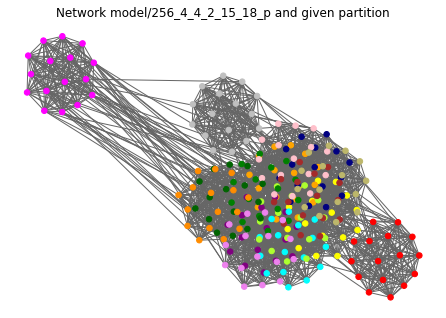

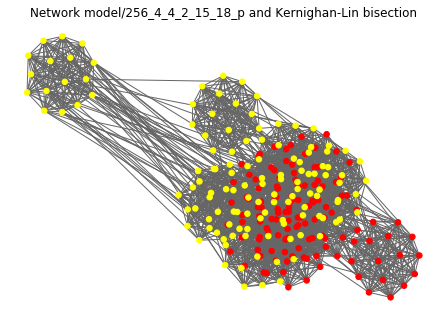

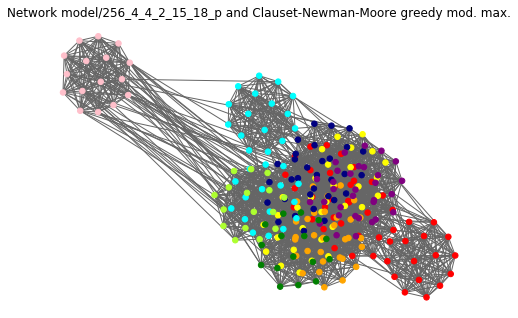

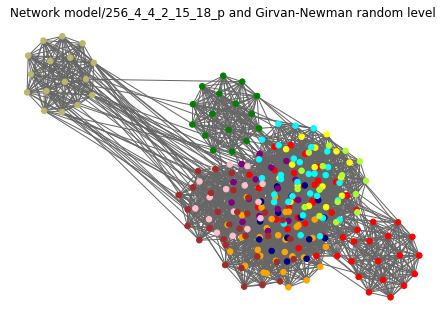

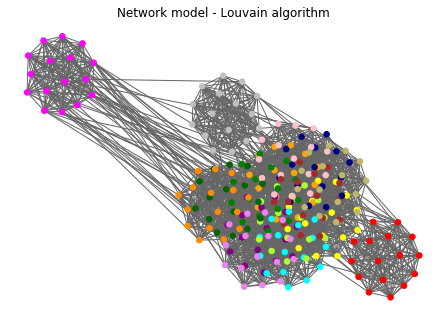

./A3-networks/model/256_4_4_4_13_18_p.net


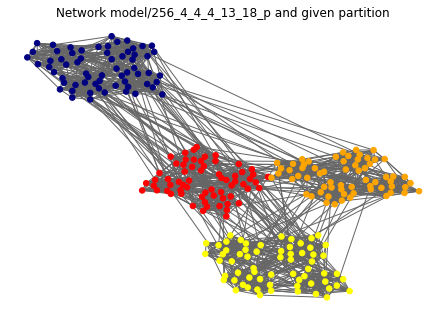

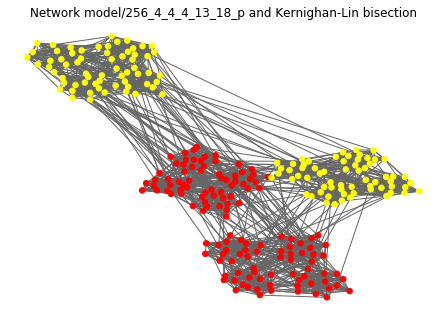

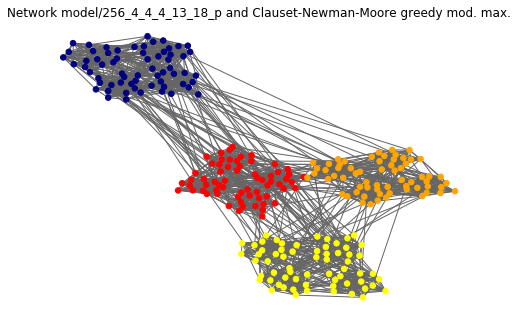

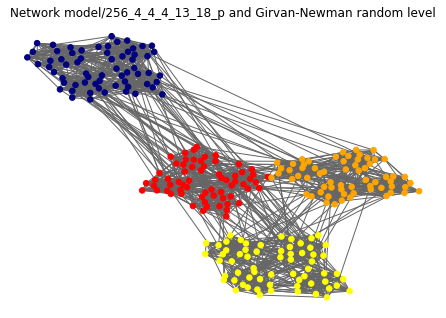

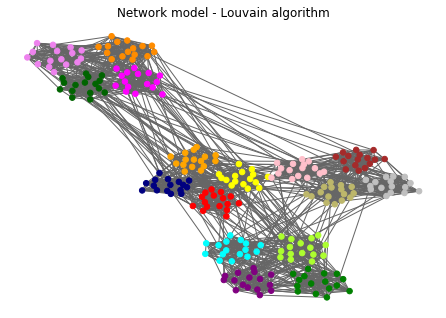

./A3-networks/real/cat_cortex_sim.net


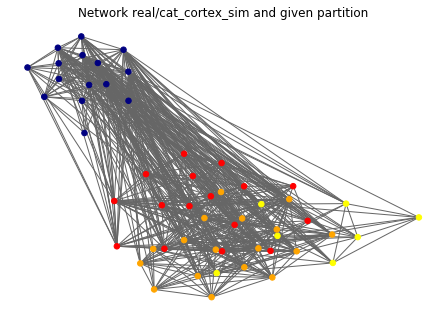

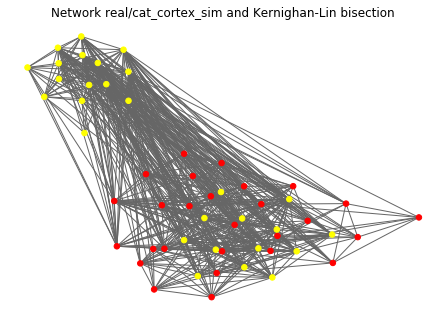

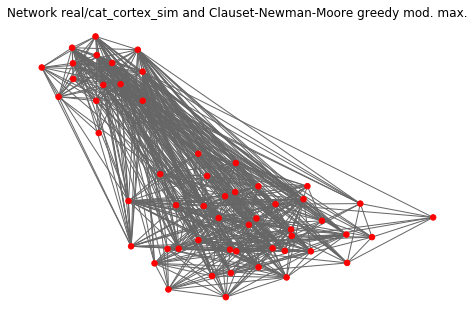

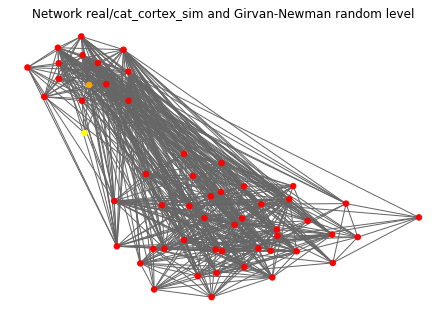

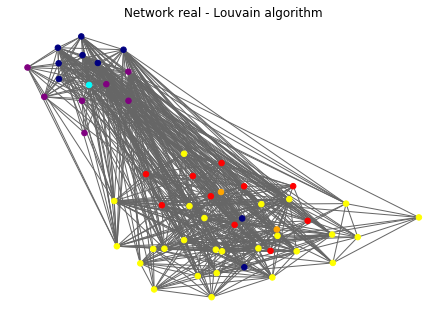

./A3-networks/real/dolphins.net


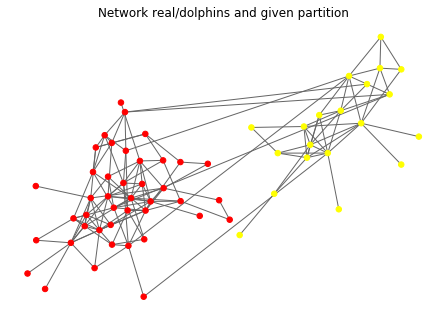

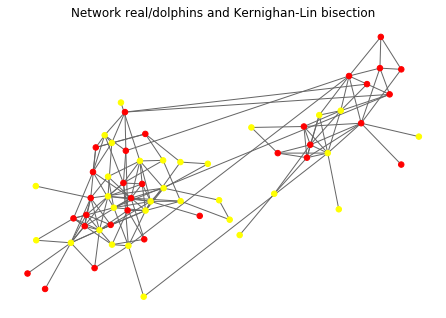

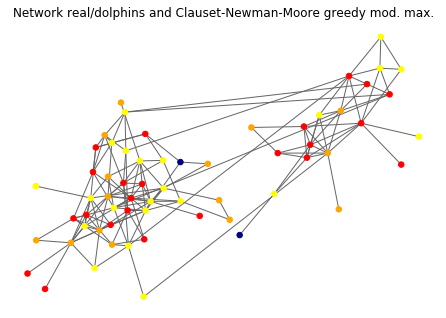

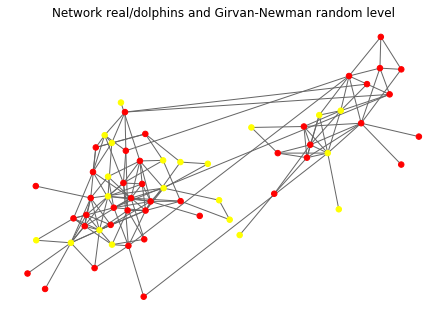

KeyError: 0

In [106]:
for file in [file for file in total_files if (not 'airports' in file and not 'rb125' in file)]:
    save_results(file)

## Analysis for model/rb125 network

In [ ]:
def save_results_sev_parts(file):
    file_parts = file.split('/')
    file_clu1 = file[:-4]+'-1.clu'
    file_clu2 = file[:-4]+'-2.clu'
    file_clu3 = file[:-4]+'-3.clu'
    
    print(file)
    
    G = nx.Graph(nx.read_pajek(file))
    given_part_dict1 = part_dict_from_file(file_clu1, G)
    given_part_dict2 = part_dict_from_file(file_clu2, G)
    given_part_dict3 = part_dict_from_file(file_clu3, G)
    
    pos = community_layout(G, given_part_dict1, 4.0)
    
    nx.draw(G, pos,node_size=25, edge_color='#666666', node_color=[colors[k-1] for k in list(given_part_dict1.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and given partition #1')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-gp-1.png')
    plt.show()
    
    nx.draw(G, pos,node_size=25, edge_color='#666666', node_color=[colors[k-1] for k in list(given_part_dict2.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and given partition #2')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-gp-2.png')
    plt.show()
    
    nx.draw(G, pos,node_size=25, edge_color='#666666', node_color=[colors[k-1] for k in list(given_part_dict3.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and given partition #3')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-gp-3.png')
    plt.show()
    
    
    # Kernighan Community
    nx_part1 = nx.community.kernighan_lin_bisection(G)
    part_dict1 = get_part_dict_from_nx_part(nx_part1)
    
    nx.draw(G, pos, node_size=25, edge_color='#666666',node_color=[colors[k] for k in list(part_dict1.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Kernighan-Lin bisection')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_KL.png')
    plt.show()
    
    save_part_dict_clu(G, part_dict1, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}-KL.clu')
    
    #  Clauset Neuman Moore
    nx_part2 = nx.community.greedy_modularity_communities(G)
    part_dict2 = get_part_dict_from_nx_part(nx_part2)
    
    nx.draw(G, pos,node_size=25, edge_color='#666666', node_color=[colors[k] for k in list(part_dict2.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Clauset-Newman-Moore greedy mod. max.')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_CNM_gr_mod.png')
    plt.show()
    
    save_part_dict_clu(G, part_dict2, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_CNM_gr_mod.clu')
    
    # Girvan Newman
    comp = nx.community.girvan_newman(G)
    if file_parts[-1].startswith('star'):
        nx_part3 = random.choice(list(comp))
    else:
        limited = itertools.takewhile(lambda c: len(c) <= len(get_nx_part_from_part_dict(given_part_dict1)), comp)
        communities = list(limited)
        nx_part3 = random.choice(communities)

    part_dict3 = get_part_dict_from_nx_part(nx_part3)

    nx.draw(G, pos, node_size=25, edge_color='#666666',node_color=[colors[k] for k in list(part_dict3.values())]); 
    plt.title(f'Network {file_parts[-2]}/{file_parts[-1][:-4]} and Girvan-Newman random level')
    plt.savefig(f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_GN_rand.png')
    plt.show()

    save_part_dict_clu(G, part_dict3, f'results/{file_parts[-2]}/{file_parts[-1][:-4]}_GN_rand.clu')
    
    
    # Calculate Leiden communities with iGraph
    G_igraph = ig.Graph.Read_Pajek(file)
    
    igraph_part4 = G_igraph.community_leiden()
    saved_file_clu = "results/{}/{}-Leiden.clu".format(file_parts[-2], file_parts[-1][:-4])
    title = "Network {} - Leiden algorithm".format(file_parts[-2], file_parts[-1][:-4])
    saved_file_png = "results/{}/{}-Leiden.png".format(file_parts[-2], file_parts[-1][:-4])
    
    save_part_igraph_dict_clu(G, igraph_part4, saved_file_clu)
    part_dict4 = part_dict_from_file(saved_file_clu, G)
    
    plot_igraph_partitions(title, saved_file_png, pos, G, igraph_part4, part_dict4)
    
    

    modularity_results.loc[f'{file_parts[-2]}/{file_parts[-1][:-4]}-1'] = (nx.community.quality.modularity(G, get_nx_part_from_part_dict(given_part_dict1)),
                                                                        nx.community.quality.modularity(G, nx_part1),
                                                                        nx.community.quality.modularity(G, nx_part2),
                                                                        nx.community.quality.modularity(G, nx_part3),
                                                                        igraph_part4.modularity)
    
    modularity_results.loc[f'{file_parts[-2]}/{file_parts[-1][:-4]}-2'] = (nx.community.quality.modularity(G, get_nx_part_from_part_dict(given_part_dict2)),
                                                                        nx.community.quality.modularity(G, nx_part1),
                                                                        nx.community.quality.modularity(G, nx_part2),
                                                                        nx.community.quality.modularity(G, nx_part3),
                                                                        igraph_part4.modularity)

    modularity_results.loc[f'{file_parts[-2]}/{file_parts[-1][:-4]}-3'] = (nx.community.quality.modularity(G, get_nx_part_from_part_dict(given_part_dict3)),
                                                                        nx.community.quality.modularity(G, nx_part1),
                                                                        nx.community.quality.modularity(G, nx_part2),
                                                                        nx.community.quality.modularity(G, nx_part3), 
                                                                        igraph_part4.modularity)

    
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-1+KL', G, given_part_dict1, part_dict1, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-1+CNM_gr_mod', G, given_part_dict1, part_dict2, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-1+GN_rand', G, given_part_dict1, part_dict3, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+Leiden', G, given_part_dict1, part_dict4, comparison_results)


    
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-2+KL', G, given_part_dict2, part_dict1, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-2+CNM_gr_mod', G, given_part_dict2, part_dict2, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-2+GN_rand', G, given_part_dict2, part_dict3, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+Leiden', G, given_part_dict2, part_dict4, comparison_results)

    
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-3+KL', G, given_part_dict3, part_dict1, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-3+CNM_gr_mod', G, given_part_dict3, part_dict2, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}-3+GN_rand', G, given_part_dict3, part_dict3, comparison_results)
    write_comparison_scores(f'{file_parts[-2]}/{file_parts[-1][:-4]}+Leiden', G, given_part_dict3, part_dict4, comparison_results)


        

./A3-networks/model/rb125.net


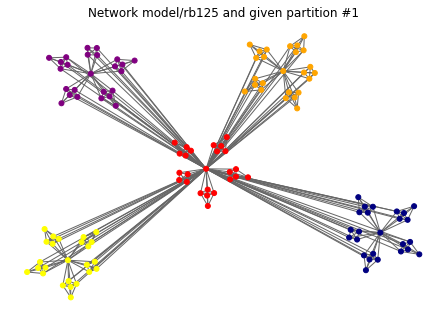

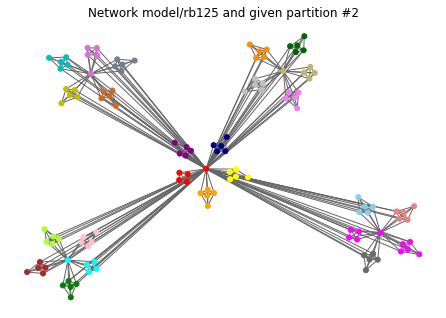

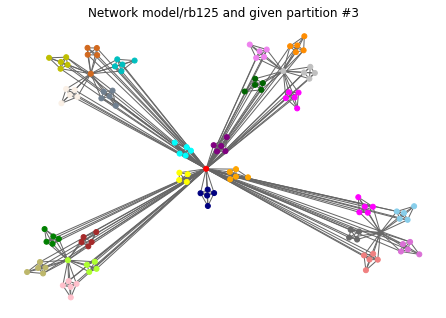

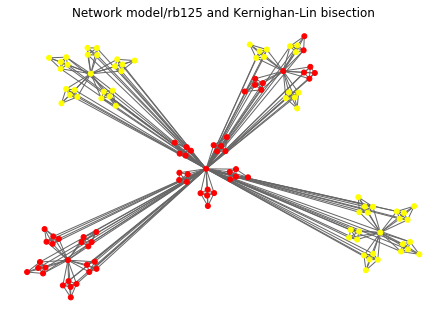

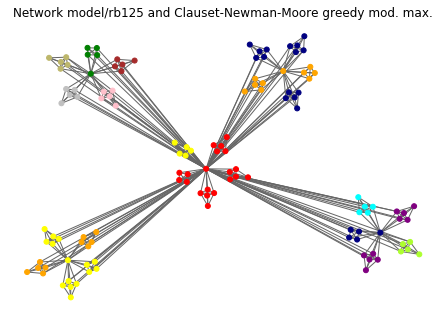

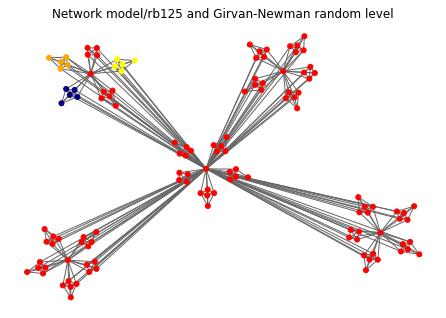

In [76]:
save_results_sev_parts('./A3-networks/model/rb125.net')

## Display Modularity Values

In [77]:
modularity_results

,Ground Truth,KL,CNM_gr_mod,GN_rand,Louvain
model/256_4_4_2_15_18_p,0.781804,0.474491,7.656598e-01,0.774489,0.781804
model/256_4_4_4_13_18_p,0.696773,0.462083,6.967733e-01,0.359520,0.663378
real/cat_cortex_sim,0.362403,0.272450,-3.102873e-17,0.001296,0.195732
real/dolphins,0.373482,0.396088,4.954907e-01,0.378703,-0.021399
real/football,0.553973,0.336643,5.497407e-01,0.598316,-0.008755
real/zachary_unwh,0.371466,0.371795,3.806706e-01,0.359961,-0.049803
toy/20x2+5x2,0.541586,0.492571,5.425785e-01,0.542579,-0.022672
toy/graph3+1+3,0.367188,0.367188,3.671875e-01,0.367188,-0.148438
toy/graph4+4,0.442857,0.442857,4.428571e-01,0.442857,-0.127219
toy/star,0.000000,-0.125000,0.000000e+00,-0.046875,-0.281250


## Display Comparison Metrics

In [78]:
comparison_results

,JS,NMI,NVI
model/256_4_4_2_15_18_p+KL,0.007812,4.000000e-01,0.375000
model/256_4_4_2_15_18_p+CNM_gr_mod,0.020833,8.697084e-01,0.115273
model/256_4_4_2_15_18_p+GN_rand,0.020833,9.265807e-01,0.068398
model/256_4_4_4_13_18_p+KL,0.125000,6.666667e-01,0.125000
model/256_4_4_4_13_18_p+CNM_gr_mod,1.000000,1.000000e+00,0.000000
model/256_4_4_4_13_18_p+GN_rand,0.083333,5.771596e-01,0.148590
real/cat_cortex_sim+KL,0.138258,4.926926e-01,0.257216
real/cat_cortex_sim+CNM_gr_mod,0.072727,3.317017e-16,0.334093
real/cat_cortex_sim+GN_rand,0.129304,1.284922e-01,0.350234
real/dolphins+KL,0.691628,4.593288e-01,0.173180
